# Download IMERG-Final data

In [1]:
import subprocess
import dask
from dask.distributed import Client, Semaphore
from pathlib import Path
import configparser
import os
import xarray as xr

In [2]:
client = Client(n_workers=os.cpu_count())
client

2023-04-24 22:41:21,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-628p32vr', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 32
Total threads: 32,Total memory: 62.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43416,Workers: 32
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.63 GiB
Comm: tcp://127.0.0.1:34076,Total threads: 1
Dashboard: http://127.0.0.1:44043/status,Memory: 1.96 GiB
Nanny: tcp://127.0.0.1:36197,


In [4]:
secrets = configparser.ConfigParser()
secrets.read('../../secrets/secrets.ini')

['../../secrets/secrets.ini']

In [5]:
download_list_fn = Path("../../data-ext-hdd/IMERG-Final/namerica/subset_GPM_3IMERGDF_06_20230424_223727_.txt")
download_dir = download_list_fn.parent
download_list = download_list_fn.read_text().split('\n')

sem = Semaphore(max_leases=4)

def download_imerg_final_url(url, sem):
    with sem:
        name = url.split('/')[-1].split('?')[0]
        result = subprocess.run(['wget', f'--user={secrets["earthdata"]["username"]}', f'--password={secrets["earthdata"]["password"]}', '--no-clobber', '-O', download_dir / name, url], capture_output=True)
    
    return result

futures = []
for url in download_list:
    future = dask.delayed(download_imerg_final_url)(url, sem)
    futures.append(future)

futures

[Delayed('download_imerg_final_url-0407b451-f1b2-4e98-8955-065740cfb3ac'),
 Delayed('download_imerg_final_url-483a33a9-e3c5-450a-967f-0e82e421fd0f'),
 Delayed('download_imerg_final_url-9d26a06e-e57c-49ae-bb72-36b299a20398'),
 Delayed('download_imerg_final_url-279a2b4c-6c5b-4e7a-a780-218ca141526b'),
 Delayed('download_imerg_final_url-94d491b1-f3f9-4cc3-9ef2-ce3713c7c0c6'),
 Delayed('download_imerg_final_url-eab8fec3-ef33-4baa-8861-0471868d2401'),
 Delayed('download_imerg_final_url-b001b350-a79d-4420-967c-0086e027b611'),
 Delayed('download_imerg_final_url-d62c6ee9-93a0-478c-92c4-989c9df4f8fb'),
 Delayed('download_imerg_final_url-bc9086f3-b382-440f-8adc-ecb53143c6e6'),
 Delayed('download_imerg_final_url-bd3ae777-ab27-44f7-9945-d87e5de3d816'),
 Delayed('download_imerg_final_url-6015e8c9-b11c-48e2-86b7-f5231af32026'),
 Delayed('download_imerg_final_url-07bb085e-5edf-467d-9e46-25a7a9b7fc92'),
 Delayed('download_imerg_final_url-42a80498-5965-451a-825a-4836f39f7bd1'),
 Delayed('download_imerg_

In [6]:
results = dask.compute(*futures)

In [3]:
# inspect downloaded file
fn = Path(f"../../data-ext-hdd/IMERG-Final/namerica/")

# dses = []

# @dask.delayed
# def load(fn):
#     try:
#         ds = xr.open_mfdataset(fn)
#         return ds
#     except:
#         fn.unlink()
#         return None

# dses = [load(f) for f in fn.glob("3B-DAY.MS.MRG.3IMERG.*.nc4")]

# combined = dask.delayed(xr.merge)(dses)
# combined

ds = xr.open_mfdataset(fn.glob("3B-DAY.MS.MRG.3IMERG.*.nc4"), parallel=True)
ds

<xarray.Dataset>
Dimensions:                    (time: 7792, lon: 683, lat: 311, nv: 2)
Coordinates:
  * lat                        (lat) float32 22.55 22.65 22.75 ... 53.45 53.55
  * lon                        (lon) float32 -126.5 -126.4 ... -58.45 -58.35
  * nv                         (nv) float32 0.0 1.0
  * time                       (time) object 2000-06-01 00:00:00 ... 2021-09-...
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    time_bnds                  (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    precipitationCal_cnt_cond  (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt        (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt_cond   (time, lon, lat) int16 dask.array<chunksize=(1, 683, 311), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2023-04-24 23:58:42 GMT Hyrax-1.16.3 https://gpm1.gesdis...

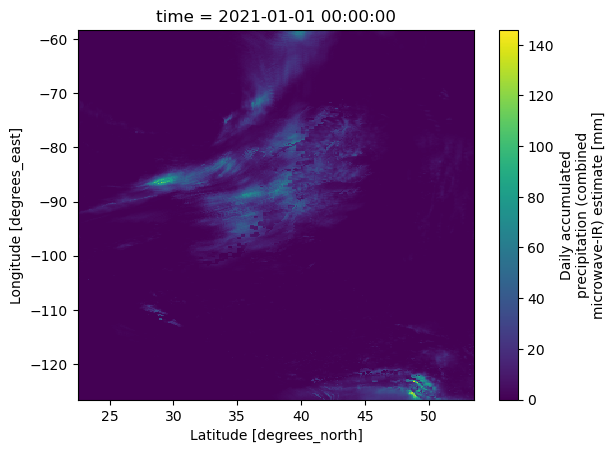

In [10]:
ds['precipitationCal'].sel(time='2021-01-01').plot()